In [2]:
import pandas as pd

# Load the data from the uploaded CSV file
file_path = 'ai4i2020.csv'
data = pd.read_csv(file_path)
print("Original Data:\n", data.head().to_markdown(index=False, numalign='left', stralign='left'))  # Display first 5 rows


Original Data:
 | UDI   | Product ID   | Type   | Air temperature [K]   | Process temperature [K]   | Rotational speed [rpm]   | Torque [Nm]   | Tool wear [min]   | Machine failure   | TWF   | HDF   | PWF   | OSF   | RNF   |
|:------|:-------------|:-------|:----------------------|:--------------------------|:-------------------------|:--------------|:------------------|:------------------|:------|:------|:------|:------|:------|
| 1     | M14860       | M      | 298.1                 | 308.6                     | 1551                     | 42.8          | 0                 | 0                 | 0     | 0     | 0     | 0     | 0     |
| 2     | L47181       | L      | 298.2                 | 308.7                     | 1408                     | 46.3          | 3                 | 0                 | 0     | 0     | 0     | 0     | 0     |
| 3     | L47182       | L      | 298.1                 | 308.5                     | 1498                     | 49.4          | 5                 |

In [3]:
from sklearn.model_selection import train_test_split
# Define the features and target variables
X = data[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']]
y = data[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']]

In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nTrain Data Shapes: X:", X_train.shape, "y:", y_train.shape)
print("Test Data Shapes: X:", X_test.shape, "y:", y_test.shape)


Train Data Shapes: X: (8000, 5) y: (8000, 5)
Test Data Shapes: X: (2000, 5) y: (2000, 5)


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


print("\nExample of Scaled X_train (First 5 Rows):\n", pd.DataFrame(X_train_scaled, columns=X.columns).head().to_markdown(numalign='left', stralign='left'))



Example of Scaled X_train (First 5 Rows):
 |    | Air temperature [K]   | Process temperature [K]   | Rotational speed [rpm]   | Torque [Nm]   | Tool wear [min]   |
|:---|:----------------------|:--------------------------|:-------------------------|:--------------|:------------------|
| 0  | -0.854066             | -0.609589                 | 0.427634                 | -0.892696     | 1.37504           |
| 1  | -0.904014             | -1.08053                  | -0.834945                | 1.38219       | 0.45762           |
| 2  | -0.904014             | -1.48419                  | -0.0596769               | -0.892696     | 1.35922           |
| 3  | 0.444571              | 0.534121                  | 0.333495                 | -0.702288     | -1.59866          |
| 4  | 0.694309              | 0.33229                   | 0.178441                 | -0.612094     | 1.58066           |


In [6]:
#Handle Class Imbalance with SMOTETomek
from imblearn.combine import SMOTETomek

smotetomek = SMOTETomek(random_state=42)

X_train_resampled_dict = {}
y_train_resampled_dict = {}

for column in y_train.columns:
    X_res, y_res = smotetomek.fit_resample(X_train_scaled, y_train[column])
    X_train_resampled_dict[column] = X_res
    y_train_resampled_dict[column] = y_res


In [7]:
import numpy as np
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

def create_cnn_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=1))
    model.add(LSTM(50, activation='relu', return_sequences=False))
    model.add(Dense(num_classes, activation='softmax'))  # Assuming 2 classes for each target variable
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_lstm_models = {}
for target in y_train.columns:
    # Reshape the data for CNN-LSTM model
    X_resampled = np.array(X_train_resampled_dict[target]).reshape(-1, X_train_scaled.shape[1], 1)
    y_resampled = to_categorical(y_train_resampled_dict[target], num_classes=2)

    # Create and train the model
    input_shape = (X_train_scaled.shape[1], 1)
    cnn_lstm_model = create_cnn_lstm_model(input_shape, num_classes=2)
    cnn_lstm_model.fit(X_resampled, y_resampled, epochs=10, batch_size=32, verbose=1)
    
    # Store the trained model
    cnn_lstm_models[target] = cnn_lstm_model


c:\Users\LENOVO\Downloads\Deep Learning\lab-master\lab\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8801 - loss: 0.3238
Epoch 2/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9592 - loss: 0.1320
Epoch 3/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9638 - loss: 0.1280
Epoch 4/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9712 - loss: 0.1061
Epoch 5/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9719 - loss: 0.1019
Epoch 6/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9722 - loss: 0.0981
Epoch 7/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9745 - loss: 0.0909
Epoch 8/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9785 - loss: 0.0807
Epoch 9/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9751 - loss: 0.0887
Epoch 10/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9794 - loss: 0.0818
Epoch 1/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8116 - loss: 0.4017
Epoch 2/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/ste

In [8]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

base_models = {
    'rf': RandomForestClassifier(random_state=42),
    'lr': LogisticRegression(random_state=42, max_iter=1000),
    'svm': SVC(kernel='linear', probability=True, random_state=42),
    'gb': GradientBoostingClassifier(random_state=42)
}

param_dist = {
    'rf': {'n_estimators': randint(50, 100), 'max_depth': [None, 10, 20]},
    'lr': {'C': uniform(0.1, 10)},
    'svm': {'C': uniform(0.1, 10)},
    'gb': {'n_estimators': randint(50, 100), 'learning_rate': uniform(0.01, 0.2)}
}

best_models = {}
for column in y_train.columns:
    best_models[column] = {}
    for model_name, model in base_models.items():
        grid_search = RandomizedSearchCV(model, param_dist[model_name], n_iter=20, cv=3, n_jobs=-1, random_state=42, verbose=1)
        grid_search.fit(X_train_scaled, y_train[column])
        best_models[column][model_name] = grid_search.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

cnn_lstm_predictions = {}
for target in y_train.columns:
    X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
    cnn_lstm_predictions[target] = np.argmax(cnn_lstm_models[target].predict(X_test_reshaped), axis=1)

traditional_predictions = {}
for column in y_train.columns:
    traditional_predictions[column] = {}
    for model_name in base_models.keys():
        traditional_predictions[column][model_name] = best_models[column][model_name].predict(X_test_scaled)

# Combine predictions using majority voting or averaging
final_predictions = np.zeros((X_test_scaled.shape[0], len(y_train.columns)), dtype=int)
for i in range(final_predictions.shape[0]):
    for j, target in enumerate(y_train.columns):
        combined_prediction = [
            cnn_lstm_predictions[target][i]
        ] + [
            traditional_predictions[target][model_name][i] for model_name in best_models[target].keys()
        ]
        final_predictions[i, j] = np.argmax(np.bincount(combined_prediction))



63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


In [10]:
# Evaluate the combined model
combined_classification_reports = {}
combined_confusion_matrices = {}
for i, target in enumerate(y_train.columns):
    combined_classification_reports[target] = classification_report(y_test[target], final_predictions[:, i])
    combined_confusion_matrices[target] = confusion_matrix(y_test[target], final_predictions[:, i])


c:\Users\LENOVO\Downloads\Deep Learning\lab-master\lab\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\Downloads\Deep Learning\lab-master\lab\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\Downloads\Deep Learning\lab-master\lab\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [11]:
# Display classification reports and confusion matrices for the combined model
for target in y_train.columns:
    print(f"Classification Report for {target}:\n{combined_classification_reports[target]}")
    print(f"Confusion Matrix for {target}:\n{combined_confusion_matrices[target]}\n")

Classification Report for TWF:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1989
           1       0.00      0.00      0.00        11

    accuracy                           0.99      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.99      0.99      0.99      2000

Confusion Matrix for TWF:
[[1989    0]
 [  11    0]]

Classification Report for HDF:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1983
           1       1.00      0.82      0.90        17

    accuracy                           1.00      2000
   macro avg       1.00      0.91      0.95      2000
weighted avg       1.00      1.00      1.00      2000

Confusion Matrix for HDF:
[[1983    0]
 [   3   14]]

Classification Report for PWF:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1980
           1       0.94      0.80   

In [12]:
 #Handle Class Imbalance with SMOTEENN
from imblearn.combine import SMOTEENN

smoteenn = SMOTEENN(random_state=42)

X_train_resampled_dict = {}
y_train_resampled_dict = {}

for column in y_train.columns:
    X_res, y_res = smoteenn.fit_resample(X_train_scaled, y_train[column])
    X_train_resampled_dict[column] = X_res
    y_train_resampled_dict[column] = y_res


In [13]:
#Train Separate Models for Each Target Variable
#CNN-LSTM Model

In [14]:
import numpy as np
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

def create_cnn_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=1))
    model.add(LSTM(50, activation='relu', return_sequences=False))
    model.add(Dense(num_classes, activation='softmax'))  # Assuming 2 classes for each target variable
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_lstm_models = {}
for target in y_train.columns:
    # Reshape the data for CNN-LSTM model
    X_resampled = np.array(X_train_resampled_dict[target]).reshape(-1, X_train_scaled.shape[1], 1)
    y_resampled = to_categorical(y_train_resampled_dict[target], num_classes=2)

    # Create and train the model
    input_shape = (X_train_scaled.shape[1], 1)
    cnn_lstm_model = create_cnn_lstm_model(input_shape, num_classes=2)
    cnn_lstm_model.fit(X_resampled, y_resampled, epochs=10, batch_size=32, verbose=1)
    
    # Store the trained model
    cnn_lstm_models[target] = cnn_lstm_model


c:\Users\LENOVO\Downloads\Deep Learning\lab-master\lab\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.8944 - loss: 0.2903
Epoch 2/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9728 - loss: 0.0891
Epoch 3/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9782 - loss: 0.0753
Epoch 4/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9828 - loss: 0.0686
Epoch 5/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9846 - loss: 0.0586
Epoch 6/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9874 - loss: 0.0504
Epoch 7/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9865 - loss: 0.0490
Epoch 8/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9904 - loss: 0.0413
Epoch 9/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9898 - loss: 0.0452
Epoch 10/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9891 - loss: 0.0417
Epoch 1/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8145 - loss: 0.3809
Epoch 2/10
490/490 ━━━━━━━━━━━━━━━━━━━━

In [15]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

base_models = {
    'rf': RandomForestClassifier(random_state=42),
    'lr': LogisticRegression(random_state=42, max_iter=1000),
    'svm': SVC(kernel='linear', probability=True, random_state=42),
    'gb': GradientBoostingClassifier(random_state=42)
}

param_dist = {
    'rf': {'n_estimators': randint(50, 100), 'max_depth': [None, 10, 20]},
    'lr': {'C': uniform(0.1, 10)},
    'svm': {'C': uniform(0.1, 10)},
    'gb': {'n_estimators': randint(50, 100), 'learning_rate': uniform(0.01, 0.2)}
}

best_models = {}
for column in y_train.columns:
    best_models[column] = {}
    for model_name, model in base_models.items():
        grid_search = RandomizedSearchCV(model, param_dist[model_name], n_iter=20, cv=3, n_jobs=-1, random_state=42, verbose=1)
        grid_search.fit(X_train_scaled, y_train[column])
        best_models[column][model_name] = grid_search.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

cnn_lstm_predictions = {}
for target in y_train.columns:
    X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
    cnn_lstm_predictions[target] = np.argmax(cnn_lstm_models[target].predict(X_test_reshaped), axis=1)

traditional_predictions = {}
for column in y_train.columns:
    traditional_predictions[column] = {}
    for model_name in base_models.keys():
        traditional_predictions[column][model_name] = best_models[column][model_name].predict(X_test_scaled)

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step


In [17]:
# Combine predictions using majority voting or averaging
final_predictions = np.zeros((X_test_scaled.shape[0], len(y_train.columns)), dtype=int)
for i in range(final_predictions.shape[0]):
    for j, target in enumerate(y_train.columns):
        combined_prediction = [
            cnn_lstm_predictions[target][i]
        ] + [
            traditional_predictions[target][model_name][i] for model_name in best_models[target].keys()
        ]
        final_predictions[i, j] = np.argmax(np.bincount(combined_prediction))

In [18]:
# Evaluate the combined model
combined_classification_reports = {}
combined_confusion_matrices = {}
for i, target in enumerate(y_train.columns):
    combined_classification_reports[target] = classification_report(y_test[target], final_predictions[:, i])
    combined_confusion_matrices[target] = confusion_matrix(y_test[target], final_predictions[:, i])

# Display classification reports and confusion matrices for the combined model
for target in y_train.columns:
    print(f"Classification Report for {target}:\n{combined_classification_reports[target]}")
    print(f"Confusion Matrix for {target}:\n{combined_confusion_matrices[target]}\n")


Classification Report for TWF:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1989
           1       0.00      0.00      0.00        11

    accuracy                           0.99      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.99      0.99      0.99      2000

Confusion Matrix for TWF:
[[1989    0]
 [  11    0]]

Classification Report for HDF:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1983
           1       1.00      0.82      0.90        17

    accuracy                           1.00      2000
   macro avg       1.00      0.91      0.95      2000
weighted avg       1.00      1.00      1.00      2000

Confusion Matrix for HDF:
[[1983    0]
 [   3   14]]

Classification Report for PWF:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1980
           1       0.94      0.80   

c:\Users\LENOVO\Downloads\Deep Learning\lab-master\lab\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\Downloads\Deep Learning\lab-master\lab\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\Downloads\Deep Learning\lab-master\lab\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [19]:
#Increase Synthetic Samples using ADASYN


In [20]:
from imblearn.over_sampling import ADASYN

# Apply ADASYN to handle class imbalance for each target variable
adasyn = ADASYN(random_state=42)

X_train_resampled_dict = {}
y_train_resampled_dict = {}

for column in y_train.columns:
    X_res, y_res = adasyn.fit_resample(X_train_scaled, y_train[column])
    X_train_resampled_dict[column] = X_res
    y_train_resampled_dict[column] = y_res


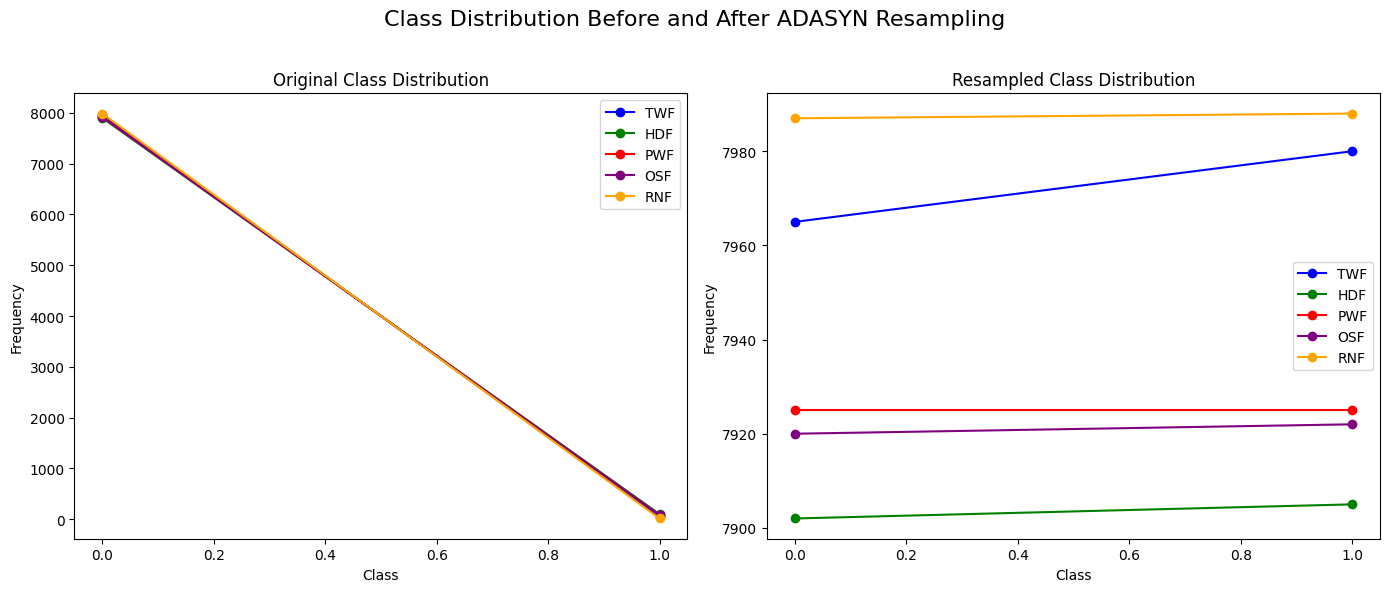

In [21]:
import matplotlib.pyplot as plt
# Plotting function

# Define colors for different target features
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Plotting function
def plot_class_distribution(y, y_resampled, title, color, ax1, ax2):
    # Original class distribution
    original_counts = y.value_counts().sort_index()
    resampled_counts = pd.Series(y_resampled).value_counts().sort_index()

    # Line plot for original class distribution
    ax1.plot(original_counts.index, original_counts.values, marker='o', color=color, label=title)
    ax1.set_title("Original Class Distribution")
    ax1.set_xlabel("Class")
    ax1.set_ylabel("Frequency")
    
    # Line plot for resampled class distribution
    ax2.plot(resampled_counts.index, resampled_counts.values, marker='o', color=color, label=title)
    ax2.set_title("Resampled Class Distribution")
    ax2.set_xlabel("Class")
    ax2.set_ylabel("Frequency")

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Class Distribution Before and After ADASYN Resampling", fontsize=16)

# Visualize class distributions for each target variable with different colors
for i, column in enumerate(y_train.columns):
    plot_class_distribution(y_train[column], y_train_resampled_dict[column], column, colors[i], ax1, ax2)

# Add legends
ax1.legend()
ax2.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [22]:
import numpy as np
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

def create_cnn_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=1))
    model.add(LSTM(50, activation='relu', return_sequences=False))
    model.add(Dense(num_classes, activation='softmax'))  # Assuming 2 classes for each target variable
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_lstm_models = {}
for target in y_train.columns:
    # Reshape the data for CNN-LSTM model
    X_resampled = np.array(X_train_resampled_dict[target]).reshape(-1, X_train_scaled.shape[1], 1)
    y_resampled = to_categorical(y_train_resampled_dict[target], num_classes=2)

    # Create and train the model
    input_shape = (X_train_scaled.shape[1], 1)
    cnn_lstm_model = create_cnn_lstm_model(input_shape, num_classes=2)
    cnn_lstm_model.fit(X_resampled, y_resampled, epochs=10, batch_size=32, verbose=1)
    
    # Store the trained model
    cnn_lstm_models[target] = cnn_lstm_model


c:\Users\LENOVO\Downloads\Deep Learning\lab-master\lab\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8638 - loss: 0.3320
Epoch 2/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9618 - loss: 0.1319
Epoch 3/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9662 - loss: 0.1180
Epoch 4/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9703 - loss: 0.1050
Epoch 5/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9727 - loss: 0.0987
Epoch 6/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9759 - loss: 0.0953
Epoch 7/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9750 - loss: 0.0863
Epoch 8/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9784 - loss: 0.0797
Epoch 9/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9765 - loss: 0.0865
Epoch 10/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9794 - loss: 0.0799
Epoch 1/10
494/494 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7992 - loss: 0.3960
Epoch 2/10
494/494 ━━━━━━━━━━━━━━━━━━━

In [24]:
# Define base models with hyperparameter grids
base_models = {
    'rf': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'lr': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'svm': SVC(kernel='linear', probability=True, random_state=42, class_weight='balanced'),
    'gb': GradientBoostingClassifier(random_state=42)
}

param_dist = {
    'rf': {'n_estimators': randint(50, 200), 'max_depth': [None, 10, 20, 30]},
    'lr': {'C': uniform(0.01, 10)},
    'svm': {'C': uniform(0.01, 10)},
    'gb': {'n_estimators': randint(50, 200), 'learning_rate': uniform(0.01, 0.2), 'max_depth': [3, 5, 10]}
}

best_models = {}
for column in y_train.columns:
    best_models[column] = {}
    for model_name, model in base_models.items():
        grid_search = RandomizedSearchCV(model, param_dist[model_name], n_iter=50, cv=5, n_jobs=-1, random_state=42, verbose=1)
        grid_search.fit(X_train_resampled_dict[column], y_train_resampled_dict[column])
        best_models[column][model_name] = grid_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 

In [25]:
# Get predictions from the CNN-LSTM models
cnn_lstm_predictions = {}
for target in y_train.columns:
    X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
    cnn_lstm_predictions[target] = np.argmax(cnn_lstm_models[target].predict(X_test_reshaped), axis=1)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [26]:
# Get predictions from the traditional models
traditional_predictions = {}
for column in y_train.columns:
    traditional_predictions[column] = {}
    for model_name in base_models.keys():
        traditional_predictions[column][model_name] = best_models[column][model_name].predict(X_test_scaled)


In [27]:
# Combine predictions using majority voting
final_predictions = np.zeros((X_test_scaled.shape[0], len(y_train.columns)), dtype=int)
for i in range(final_predictions.shape[0]):
    for j, target in enumerate(y_train.columns):
        combined_prediction = [
            cnn_lstm_predictions[target][i]
        ] + [
            traditional_predictions[target][model_name][i] for model_name in best_models[target].keys()
        ]
        final_predictions[i, j] = np.argmax(np.bincount(combined_prediction))


In [28]:
# Evaluate the combined model
combined_classification_reports = {}
combined_confusion_matrices = {}
for i, target in enumerate(y_train.columns):
    combined_classification_reports[target] = classification_report(y_test[target], final_predictions[:, i])
    combined_confusion_matrices[target] = confusion_matrix(y_test[target], final_predictions[:, i])


In [29]:
# Display classification reports and confusion matrices for the combined model
for target in y_train.columns:
    print(f"Classification Report for {target}:\n{combined_classification_reports[target]}")
    print(f"Confusion Matrix for {target}:\n{combined_confusion_matrices[target]}\n")


Classification Report for TWF:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1989
           1       0.09      0.55      0.16        11

    accuracy                           0.97      2000
   macro avg       0.55      0.76      0.57      2000
weighted avg       0.99      0.97      0.98      2000

Confusion Matrix for TWF:
[[1931   58]
 [   5    6]]

Classification Report for HDF:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1983
           1       0.63      1.00      0.77        17

    accuracy                           0.99      2000
   macro avg       0.81      1.00      0.89      2000
weighted avg       1.00      0.99      1.00      2000

Confusion Matrix for HDF:
[[1973   10]
 [   0   17]]

Classification Report for PWF:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1980
           1       0.53      1.00   

In [30]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier

# Define base models
base_models = [
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced')),
    ('lr', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')),
    ('svm', SVC(kernel='linear', probability=True, random_state=42, class_weight='balanced')),
    ('gb', GradientBoostingClassifier(random_state=42))
]

# Define meta-model
meta_model = LogisticRegression(random_state=42)

# Create and train the stacking model for each target variable
stacking_models = {}
for column in y_train.columns:
    stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)
    stacking_model = stacking_clf.fit(X_train_resampled_dict[column], y_train_resampled_dict[column])
    stacking_models[column] = stacking_model


In [31]:
from sklearn.metrics import classification_report, confusion_matrix

cnn_lstm_predictions = {}
for target in y_train.columns:
    X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
    cnn_lstm_predictions[target] = np.argmax(cnn_lstm_models[target].predict(X_test_reshaped), axis=1)

stacking_predictions = {}
for column in y_train.columns:
    stacking_predictions[column] = stacking_models[column].predict(X_test_scaled)

# Combine predictions using majority voting
final_predictions = np.zeros((X_test_scaled.shape[0], len(y_train.columns)), dtype=int)
for i in range(final_predictions.shape[0]):
    for j, target in enumerate(y_train.columns):
        combined_prediction = [
            cnn_lstm_predictions[target][i],
            stacking_predictions[target][i]
        ]
        final_predictions[i, j] = np.argmax(np.bincount(combined_prediction))

# Evaluate the combined model
combined_classification_reports = {}
combined_confusion_matrices = {}
for i, target in enumerate(y_train.columns):
    combined_classification_reports[target] = classification_report(y_test[target], final_predictions[:, i])
    combined_confusion_matrices[target] = confusion_matrix(y_test[target], final_predictions[:, i])

# Display classification reports and confusion matrices for the combined model
for target in y_train.columns:
    print(f"Classification Report for {target}:\n{combined_classification_reports[target]}")
    print(f"Confusion Matrix for {target}:\n{combined_confusion_matrices[target]}\n")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report for TWF:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1989
           1       0.14      0.55      0.22        11

    accuracy                           0.98      2000
   macro avg       0.57      0.76      0.60      2000
weighted avg       0.99      0.98      0.98      2000

Confusion Matrix for TWF:
[[1951   38]
 [   5    6]]

Classification Report for HDF:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1983
           1       0.73      0.94      0.82        17

    accuracy                           1.00      2000
   macro avg       0.86      0.97      0.91      2000
weighted avg       1.00      1.00      1.00      2000

Confusion Matrix for HDF:
[[1977   